# Used Car Price Prediction Project

This application will predict the prices of used cars using a RandomForestRegressor.
   
The data set is downloaded from kaggle https://www.kaggle.com/ishaanthareja007/car-details
The data will be split into 3 sets: training.csv, validation.csv, and testing.csv sets
    
We will use RMSLE (root mean squared log error), MAPE (mean absolute percentage error), and R Squared error to determine the accuracy of the predicted prices

# Import data

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

In [32]:
# import training and validation data into a dataframe
df = pd.read_csv("data/car-data.csv")

# Explore data

This shows the structure of the CSV file that we are using.

The price is in Rupees as the used car company is headquartered in India
and the mileage is in Kilometers.

The unit types do not interfere with the machine learning algorithm as long as they are consistent

In [33]:
# Display the DataFrame
df.head()

,name,year,price,mileage,fuel,seller_type,transmission,owner,kmpl,engine,max_power,torque,seats
0,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14 kmpl,1498 CC,103.52 bhp,250Nm@ 1500-2500rpm,5.0
1,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,Third Owner,17.7 kmpl,1497 CC,78 bhp,"12.7@ 2,700(kgm@ rpm)",5.0
2,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.0 kmpl,1396 CC,90 bhp,22.4 kgm at 1750-2750rpm,5.0
3,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.1 kmpl,1298 CC,88.2 bhp,"11.5@ 4,500(kgm@ rpm)",5.0
4,Hyundai Xcent 1.2 VTVT E Plus,2017,440000,45000,Petrol,Individual,Manual,First Owner,20.14 kmpl,1197 CC,81.86 bhp,113.75nm@ 4000rpm,5.0


Next, we examine more info about the size of the dataframe and its content

Here we can see the total entries, column types and the number of missing values

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8127 entries, 0 to 8126
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   name          8127 non-null   object 
 1   year          8127 non-null   int64  
 2   price         8127 non-null   int64  
 3   mileage       8127 non-null   int64  
 4   fuel          8127 non-null   object 
 5   seller_type   8127 non-null   object 
 6   transmission  8127 non-null   object 
 7   owner         8127 non-null   object 
 8   kmpl          7906 non-null   object 
 9   engine        7906 non-null   object 
 10  max_power     7912 non-null   object 
 11  torque        7905 non-null   object 
 12  seats         7906 non-null   float64
dtypes: float64(1), int64(3), object(9)
memory usage: 825.5+ KB


### Visualize relationships among data

It is not necessary to assess the correlation between price and all columns right now as we can use our machine learning algorithm to assess the strengths of these relationships later. However, we will explore some relationships here.

We create a scatter plot comparing mileage and price.This graph shows a strong correlation. 
(lower mileage cars sell for higher prices)

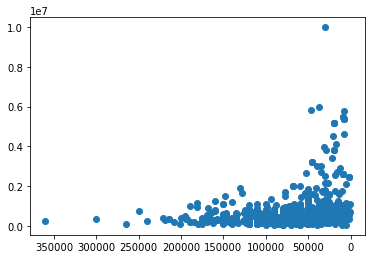

In [35]:
fig, ax = plt.subplots()
ax.invert_xaxis()
ax.scatter(df["mileage"][:1000], df["price"][:1000])

We create a bar graph comparing year vs price. This graph also shows a strong relationship. (newer models sell for higher prices)

<BarContainer object of 1000 artists>

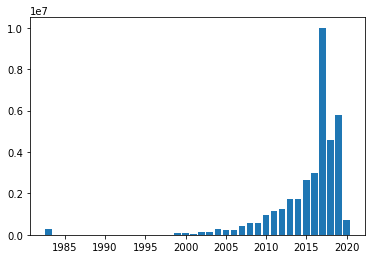

In [36]:
fig, ax = plt.subplots()
ax.bar(df["year"][:1000], df["price"][:1000])

# Clean and Transform Data

### Create a data formatting function
This function will convert any objects or strings to categorical types for the machine learning algorithm

This function will also fill null values

In [37]:
def format_data(df):
    
    # Fill missing numeric columns with median
    # Add additional column to indicate missing data was replaced
    for label, content in df.items():
        if pd.api.types.is_numeric_dtype(content):
            if pd.isnull(content).sum():
                # fill missing data and add a column to indicate data was missing
                df[label] = content.fillna(content.median())

    # convert objects/strings to categorical data types for our ML algorithm
    for label, content in df.items():
        if pd.api.types.is_string_dtype(content):
            df[label] = content.astype("category").cat.as_ordered()
            
    # fill missing categorical values
    for label, content in df.items():
        if not pd.api.types.is_numeric_dtype(content):
            df[label] = pd.Categorical(content).codes + 1 # missing values are -1 so we add 1 to everything to make them 0
    return df

In [38]:
# Format the DataFrame 
df = format_data(df)

# View the new details of the dataframe and make sure the formatting was successful
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8127 entries, 0 to 8126
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   name          8127 non-null   int16  
 1   year          8127 non-null   int64  
 2   price         8127 non-null   int64  
 3   mileage       8127 non-null   int64  
 4   fuel          8127 non-null   int8   
 5   seller_type   8127 non-null   int8   
 6   transmission  8127 non-null   int8   
 7   owner         8127 non-null   int8   
 8   kmpl          8127 non-null   int16  
 9   engine        8127 non-null   int8   
 10  max_power     8127 non-null   int16  
 11  torque        8127 non-null   int16  
 12  seats         8127 non-null   float64
dtypes: float64(1), int16(4), int64(3), int8(5)
memory usage: 357.3 KB


We can see below, "torque" and "engine" may have a weak correlation with price

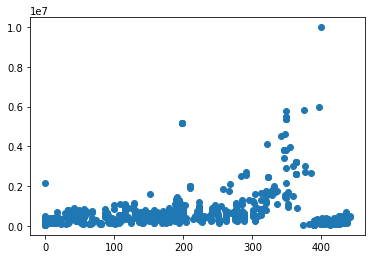

In [39]:
fig, ax = plt.subplots()
ax.scatter(df["torque"][:1000], df["price"][:1000])

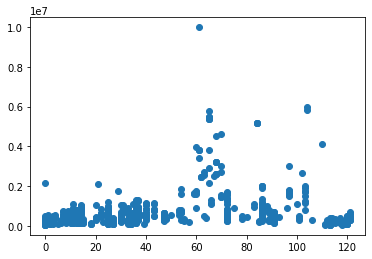

In [40]:
fig, ax = plt.subplots()
ax.scatter(df["engine"][:1000], df["price"][:1000])

# Split the Data

Split the data into training, test, and validation sets for the ML algorithm

In [41]:
dftest = df[df.index >= 7900]
dfval = df[np.logical_and(df.index >= 7600, df.index < 7900)]
dftrain = df[df.index < 7600]

### Verify that the sets were split appropriately

As we can see, the sets were split from the original with 8127 entries into 3 separate sets

In [42]:
len(dfval), len(dftrain), len(dftest)

(300, 7600, 227)

# Evaluate the Machine Learning model

### Create a function to evaluate the accuracy of the machine learning model and display results

In [43]:
# We will use the MSLE, MAPE, and R^2 score for evaluation metrics
from sklearn.metrics import mean_squared_log_error, mean_absolute_percentage_error, r2_score

# function to find RMSLE since it is not available in sklearn
def rmsle(y_actual, y_pred):
    return np.sqrt(mean_squared_log_error(y_actual, y_pred))

# make a function that evaluates the model with different criteria
def score_model(model):
    train_pred = model.predict(xtrain) # see how model performs on training set
    val_pred = model.predict(xvalid) # see how model performs on validation set
    
    # scores will return a dictionary with the results
    scores = {"Training MAPE": mean_absolute_percentage_error(ytrain, train_pred),
              "Validation MAPE": mean_absolute_percentage_error(yvalid, val_pred),
              "Training RMSLE": rmsle(ytrain, train_pred),
              "validation RMSLE": rmsle(yvalid, val_pred),
              "Training R^2": r2_score(ytrain, train_pred),
              "Validation R^2": r2_score(yvalid, val_pred)}
    return scores

# Build the Machine Learning Model

### Create the training and validation sets

Here we will separate the "price" column from the training and validation sets in order to train and evaluate the model

In [44]:
# xtrain is the training data without the price column and ytrain is the associated price column (similar for xvalid/yvalid)
xtrain, ytrain = dftrain.drop("price", axis=1), dftrain.price
xvalid, yvalid = dfval.drop("price", axis=1), dfval.price

Next, we will verify the data by printing the number of rows and columns

In [45]:
xtrain.shape, ytrain.shape, xvalid.shape, yvalid.shape

((7600, 12), (7600,), (300, 12), (300,))

### Instantiate and fit the model

In [46]:
%%time

from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_jobs=-1, random_state=42)

#fit model with training set
model.fit(xtrain, ytrain)

Wall time: 1.53 s


RandomForestRegressor(n_jobs=-1, random_state=42)

## Score the model

MAPE: A lower is better, less than .3 or 30% is required

RMSLE: A lower number is better .25 is considered a good value

R^2: A number close to 1 is best, greater than .8 or 80% is required

In [47]:
score_model(model)

{'Training MAPE': 0.05863368208471419,
 'Validation MAPE': 0.1422224209310118,
 'Training RMSLE': 0.09390528259457104,
 'validation RMSLE': 0.20138967545119008,
 'Training R^2': 0.9936820542168712,
 'Validation R^2': 0.9840866448419034}

## Improve the model

Try to improve the model by finding the best hyperparameters for the model using RandomizedSearchCV

In [48]:
%%time
# takes model and searches for the best hyperparameters

from sklearn.model_selection import RandomizedSearchCV

rf = {"n_estimators": np.arange(10, 100, 10),
      "max_depth": [None, 3, 5, 10],
      "min_samples_split": np.arange(2, 20, 2),
      "min_samples_leaf": np.arange(1, 20, 2),
      "max_features": [0.5, 1, "sqrt", "auto"],
      "max_samples": [6080]}

rsModel = RandomizedSearchCV(RandomForestRegressor(n_jobs=-1, random_state = 42), param_distributions=rf,
                                                    n_iter=10, cv=5, verbose=True)
    
rsModel.fit(xtrain, ytrain)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Wall time: 7.27 s


RandomizedSearchCV(cv=5,
                   estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'max_features': [0.5, 1, 'sqrt',
                                                         'auto'],
                                        'max_samples': [6080],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([10, 20, 30, 40, 50, 60, 70, 80, 90])},
                   verbose=True)

### Fit model with better hyperparameters

In [49]:
# Find the optimal paramaters given by RandomizedSearchCV
rsModel.best_params_

{'n_estimators': 60,
 'min_samples_split': 8,
 'min_samples_leaf': 5,
 'max_samples': 6080,
 'max_features': 'sqrt',
 'max_depth': 10}

In [50]:
# after 100 iterations, we will try the parameters from RandomizedSearchCV

updated_model = RandomForestRegressor(n_estimators=40, min_samples_split=4, min_samples_leaf=1,
                                  max_samples=6080, max_features=0.5, max_depth=None, random_state=42)
updated_model.fit(xtrain, ytrain)

RandomForestRegressor(max_features=0.5, max_samples=6080, min_samples_split=4,
                      n_estimators=40, random_state=42)

As we can see below, the updated model scored a better R Squared value but was around the same or slightly worse in the other categories

In [51]:
# Show the updated model's scores
score_model(updated_model)

{'Training MAPE': 0.08571020406190272,
 'Validation MAPE': 0.14535801815003155,
 'Training RMSLE': 0.1263745900504039,
 'validation RMSLE': 0.20418752442027152,
 'Training R^2': 0.991404684026345,
 'Validation R^2': 0.986575834460972}

## Format test set

In [52]:
# copy the test set into a new dataframe and drop the price column

pd.options.mode.chained_assignment = None  # default='warn' -- suppress warning for modifying a DF copy
dftest1 = dftest.copy()
dftest1.drop(["price"], axis=1, inplace=True)
dftest1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 227 entries, 7900 to 8126
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   name          227 non-null    int16  
 1   year          227 non-null    int64  
 2   mileage       227 non-null    int64  
 3   fuel          227 non-null    int8   
 4   seller_type   227 non-null    int8   
 5   transmission  227 non-null    int8   
 6   owner         227 non-null    int8   
 7   kmpl          227 non-null    int16  
 8   engine        227 non-null    int8   
 9   max_power     227 non-null    int16  
 10  torque        227 non-null    int16  
 11  seats         227 non-null    float64
dtypes: float64(1), int16(4), int64(2), int8(5)
memory usage: 10.0 KB


## Now we can make predictions on test data

In [53]:
# predict data from test set using the model
test_pred = updated_model.predict(dftest1)

# create a dataframe with the predicted prices and actual prices to graph the results
resultdf = pd.DataFrame()
resultdf["actualPrice"] = dftest["price"]
resultdf["predictedPrice"] = test_pred
# resultdf

### Display the results and compare the predictions with actual prices

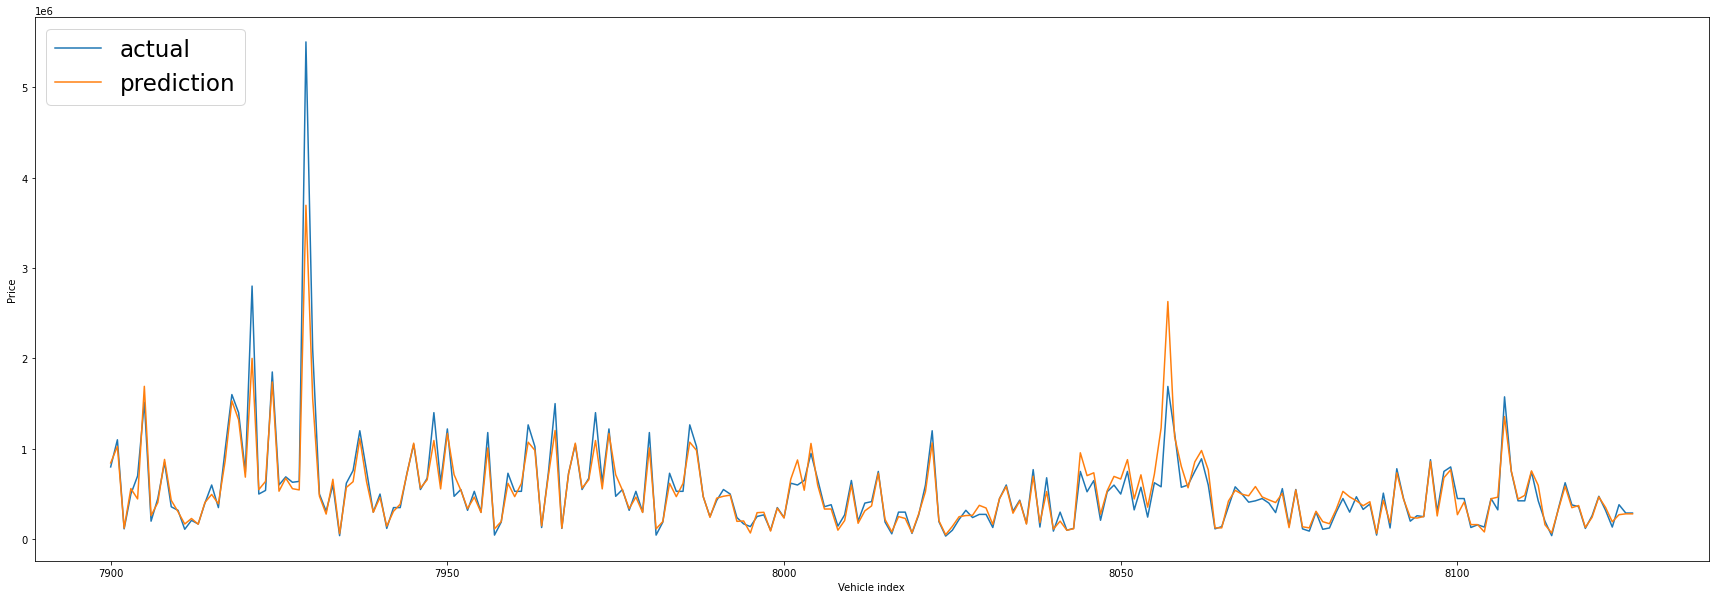

In [54]:
# Graph the actual and predicted prices to compare (x=index, y=price)
from matplotlib.pyplot import figure

plt.figure(figsize=(30,10))
plt.plot(resultdf.index, resultdf["actualPrice"], label="actual") # blue
plt.plot(resultdf.index, resultdf["predictedPrice"], label="prediction") # orange

plt.legend()
plt.legend(loc=2, prop={'size': 23})
plt.xlabel("Vehicle index")
plt.ylabel("Price")


plt.rcParams.update({'font.size': 23})

The graph above demonstrates the accuracy of the model for predicting prices

The results below also demonstrate that the model has achieved the objective accuracy targets (greater than 80% R^2 and less than 30% MAPE)

In [55]:
print("Test R^2", r2_score(dftest["price"], test_pred))
print("Test RMSLE", rmsle(dftest["price"], test_pred))
print("Test MAPE", mean_absolute_percentage_error(dftest["price"], test_pred))

Test R^2 0.880016970547083
Test RMSLE 0.21947328063993593
Test MAPE 0.17014862257005794


In [57]:
dftest.tail()

,name,year,price,mileage,fuel,seller_type,transmission,owner,kmpl,engine,max_power,torque,seats
8122,772,2013,320000,110000,4,2,2,1,203,11,268,38,5.0
8123,657,2007,135000,119000,2,2,2,2,155,33,31,251,5.0
8124,1320,2009,382000,120000,2,2,2,1,223,14,242,179,5.0
8125,1700,2013,290000,25000,2,2,2,1,338,25,233,107,5.0
8126,1700,2013,290000,25000,2,2,2,1,338,25,233,107,5.0
